## Loading Steinmetz data

In [57]:
%pip install requests --quiet

Note: you may need to restart the kernel to use updated packages.


In [33]:
import os, requests
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams 
import seaborn as sns
import pandas as pd
import glob

In [110]:
## Defaults
data_path = './pickled_data/'
plot_path = './plots/'
os.makedirs(data_path, exist_ok=True)
os.makedirs(plot_path, exist_ok=True)
sns.set(context='poster', style='white', palette='muted')

In [4]:
#@title Data retrieval
fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [5]:
#@title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'lfp', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'brain_area_lfp', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'waveform_w', 'waveform_u', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'lfp_passive', 'pupil_passive', 'wheel_passive'])


In [153]:
dat['brain_area_lfp']

['DG',
 'LGd',
 'SUB',
 'VISp',
 'ACA',
 'MOs',
 'PL',
 'CA1',
 'DG',
 'LH',
 'MD',
 'VISam']

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the following fields:

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: exact position of the wheel that the mice uses to make a response, binned at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position. 
* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `lfp`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 




## Spike data

In [ ]:
#dataframe with spike info for each session, mouse and trial. Columns signify time bins of 10ms
spike_df = pd.DataFrame() 
#loop through all sessions
for session, data in enumerate(alldat):
    #loop through trial_data from all neurons
    for neuron_num, neuron_data in enumerate(data['spks']):
#         print(neuron_data.shape)
        tmpdf = pd.DataFrame(neuron_data, columns=list(range(neuron_data.shape[1])))
        tmpdf['trial_num'] = tmpdf.index.values
        tmpdf['neuron_num'] = neuron_num 
        tmpdf['neuron_location'] = data['brain_area'][neuron_num]
        tmpdf['session'] = session
        tmpdf['mouse_name'] = data['mouse_name']
        spike_df = pd.concat([spike_df, tmpdf], ignore_index=True)
    if session !=0 and session%10 == 0:
        spike_df.to_pickle(f'{data_path}/mouse_data_{session//10}.pkl')
        spike_df = pd.DataFrame()
    else:
        continue
    
spike_df.to_pickle(f'{data_path}/mouse_data_4.pkl')
spike_df.head()

In [ ]:
spike_df = pd.concat([pd.read_pickle(fname) for fname in glob.glob(f'{data_path}/mouse_data_*')])
spike_df.set_index(['session', 'mouse_name','trial_num','neuron_num','neuron_location',])

In [55]:
spike_df.neuron_location.unique().astype(list)

array(['ACA', 'MOs', 'LS', 'root', 'VISp', 'CA3', 'SUB', 'DG', 'CA1',
       'VISl', 'VISpm', 'POST', 'VISam', 'MG', 'SPF', 'LP', 'MRN', 'NB',
       'LGd', 'TH', 'VPL', 'VISa', 'LSr', 'OLF', 'ORB', 'PL', 'AUD',
       'SSp', 'LD', 'CP', 'EPd', 'PIR', 'ILA', 'TT', 'PO', 'ORBm', 'MB',
       'SCm', 'SCsg', 'POL', 'GPe', 'VISrl', 'MOp', 'LSc', 'PT', 'MD',
       'LH', 'ZI', 'SCs', 'RN', 'MS', 'RSP', 'PAG', 'BLA', 'VPM', 'SSs',
       'RT', 'MEA', 'ACB', 'OT', 'SI', 'SNr', 'APN', 'VAL', 'IC', 'CA2',
       'SCig', 'DP', 'CL', 'EP', 'BMA', 'COA', 'CA'], dtype=object)

In [81]:
spike_df.set_index(['session', 'mouse_name','trial_num','neuron_num','neuron_location',]).head()

0    1    2    3    \
session mouse_name trial_num neuron_num neuron_location                       
0       Cori       0         0          ACA                0    0    0    0   
                   1         0          ACA                0    0    0    0   
                   2         0          ACA                0    0    0    0   
                   3         0          ACA                0    0    0    0   
                   4         0          ACA                0    0    0    0   

                                                         4    5    6    7    \
session mouse_name trial_num neuron_num neuron_location                       
0       Cori       0         0          ACA                0    0    0    0   
                   1         0          ACA                0    0    0    0   
                   2         0          ACA                0    0    0    0   
                   3         0          ACA                0    0    0    0   
                   4         0          ACA                0    0    0    0   

                                                         8    9    ...  240  \
session mouse_name trial_num neuron_num neuron_location            ...        
0       Cori       0         0          ACA                0    0  ...    0   
                   1         0          ACA                0    0  ...    0   
                   2         0          ACA                0    0  ...    0   
                   3         0          ACA                0    0  ...    0   
                   4         0          ACA                0    0  ...    0   

                                                         241  242  243  244  \
session mouse_name trial_num neuron_num neuron_location                       
0       Cori       0         0          ACA                0    0    0    0   
                   1         0          ACA                0    0    0    0   
                   2         0          ACA                0    0    0    0   
                   3         0          ACA                0    0    0    0   
                   4         0          ACA                0    0    0    0   

                                                         245  246  247  248  \
session mouse_name trial_num neuron_num neuron_location                       
0       Cori       0         0          ACA                0    0    0    0   
                   1         0          ACA                0    0    0    0   
                   2         0          ACA                0    0    0    0   
                   3         0          ACA                0    0    0    0   
                   4         0          ACA                0    0    0    0   

                                                         249  
session mouse_name trial_num neuron_num neuron_location       
0       Cori       0         0          ACA                0  
                   1         0          ACA                0  
                   2         0          ACA                0  
                   3         0          ACA                0  
                   4         0          ACA                0  

[5 rows x 250 columns]

In [218]:
(
    spike_df
#     .query('neuron_location == "VISa"')
    .set_index(['session', 'mouse_name','trial_num','neuron_num','neuron_location',])
    .groupby(['session', 'mouse_name',])[0]
    .count()
)

session  mouse_name
0        Cori          157076
1        Cori          268570
2        Cori          141132
3        Forssmann     440481
4        Forssmann     273558
5        Forssmann     339010
6        Forssmann     147168
7        Hench         289000
8        Hench         293136
9        Hench         523884
10       Hench         293094
11       Lederberg     237320
12       Lederberg     294900
13       Lederberg     202608
14       Lederberg     300172
15       Lederberg     132720
16       Lederberg     126560
17       Lederberg     344124
18       Moniz         149682
19       Moniz         211265
20       Moniz          71672
21       Muller        286824
22       Muller        191468
23       Muller        250019
24       Radnitz       230985
25       Radnitz       187968
26       Radnitz       142439
27       Radnitz        77958
28       Radnitz        96000
29       Richards      134706
30       Richards      231549
31       Richards      135720
32       Richards   

Number of recorded brain areas: 73


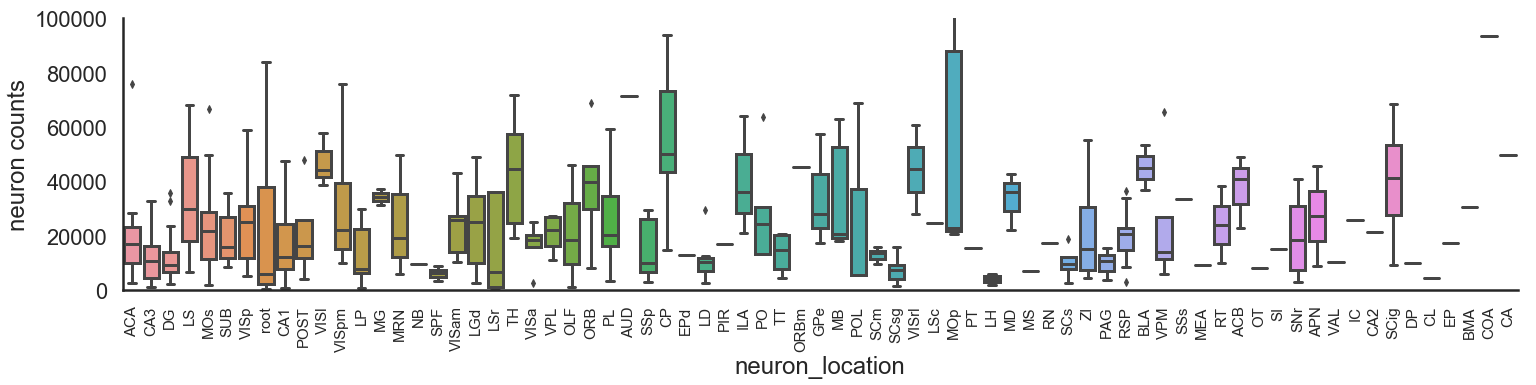

In [166]:
tmpdf = (
    spike_df
#     .query('neuron_location == "VISa"')
    .set_index(['session', 'mouse_name','trial_num','neuron_num','neuron_location',])
    .groupby(['session', 'mouse_name', 'neuron_location'])[0]
    .count()
    .rename('counts')
    .reset_index()
)

_, ax = plt.subplots(figsize=(25,5))
sns.boxplot(x='neuron_location', y='counts', data=tmpdf,)
sns.despine()
ax.set_ylim(0,100000)
ax.set_ylabel('neuron counts')
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90, fontsize=15);
print(f'Number of recorded brain areas: {len(ax.get_xticklabels())}')

## LFP Data

In [157]:
#dataframe with spike info for each session, mouse and trial. Columns signify time bins of 10ms
lfp_df = pd.DataFrame() 
#loop through all sessions
for session, data in enumerate(alldat):
    #loop through trial_data from all neurons
    for lfp_num, lfp_data in enumerate(data['lfp']):
#         print(neuron_data.shape)
        tmpdf = pd.DataFrame(lfp_data, columns=list(range(lfp_data.shape[1])))
        tmpdf['trial_num'] = tmpdf.index.values
        tmpdf['lfp_num'] = lfp_num
        tmpdf['lfp_location'] = data['brain_area_lfp'][lfp_num]
        tmpdf['session'] = session
        tmpdf['mouse_name'] = data['mouse_name']
        lfp_df = pd.concat([lfp_df, tmpdf], ignore_index=True)
#     if session !=0 and session%20 == 0:
#         lfp_df.to_pickle(f'{data_path}/mouse_data_lfp_{session//20}.pkl')
#         lfp_df = pd.DataFrame()
    else:
        continue
    
# lfp_df.to_pickle(f'{data_path}/mouse_data_lfp_2.pkl')
lfp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,245,246,247,248,249,trial_num,lfp_num,lfp_location,session,mouse_name
0,-2.850794,-4.039683,-4.195238,-3.228571,0.460317,6.749206,15.949206,3.438095,1.193651,18.515873,...,7.715873,1.593651,0.726984,-2.217460,10.993651,0,0,ACA,0,Cori
1,9.142630,11.475964,14.764853,11.609297,10.087075,6.287075,1.020408,-9.490703,-16.690703,-16.035147,...,4.920408,15.053741,3.031519,9.209297,7.975964,1,0,ACA,0,Cori
2,2.656689,4.545578,7.656689,6.512245,-4.698866,-10.309977,-15.332200,-16.643311,-7.065533,8.534467,...,-10.687755,-15.098866,-17.987755,-17.654422,-11.543311,2,0,ACA,0,Cori
3,-9.866213,-12.632880,-8.232880,-15.021769,-7.699546,5.456009,0.122676,11.489342,19.267120,7.733787,...,-10.455102,-4.243991,-6.155102,-4.299546,-16.866213,3,0,ACA,0,Cori
4,13.496145,22.851701,24.296145,27.840590,29.162812,23.062812,23.462812,23.007256,15.862812,5.762812,...,4.040590,-3.526077,5.407256,5.540590,-0.514966,4,0,ACA,0,Cori


In [216]:
(lfp_df
#     .query('neuron_location == "VISa"')
    .set_index(['session', 'mouse_name','trial_num','lfp_num','lfp_location',])
).head()

0          1    \
session mouse_name trial_num lfp_num lfp_location                         
0       Cori       0         0       ACA           -2.850794  -4.039683   
                   1         0       ACA            9.142630  11.475964   
                   2         0       ACA            2.656689   4.545578   
                   3         0       ACA           -9.866213 -12.632880   
                   4         0       ACA           13.496145  22.851701   

                                                         2          3    \
session mouse_name trial_num lfp_num lfp_location                         
0       Cori       0         0       ACA           -4.195238  -3.228571   
                   1         0       ACA           14.764853  11.609297   
                   2         0       ACA            7.656689   6.512245   
                   3         0       ACA           -8.232880 -15.021769   
                   4         0       ACA           24.296145  27.840590   

                                                         4          5    \
session mouse_name trial_num lfp_num lfp_location                         
0       Cori       0         0       ACA            0.460317   6.749206   
                   1         0       ACA           10.087075   6.287075   
                   2         0       ACA           -4.698866 -10.309977   
                   3         0       ACA           -7.699546   5.456009   
                   4         0       ACA           29.162812  23.062812   

                                                         6          7    \
session mouse_name trial_num lfp_num lfp_location                         
0       Cori       0         0       ACA           15.949206   3.438095   
                   1         0       ACA            1.020408  -9.490703   
                   2         0       ACA          -15.332200 -16.643311   
                   3         0       ACA            0.122676  11.489342   
                   4         0       ACA           23.462812  23.007256   

                                                         8          9    ...  \
session mouse_name trial_num lfp_num lfp_location                        ...   
0       Cori       0         0       ACA            1.193651  18.515873  ...   
                   1         0       ACA          -16.690703 -16.035147  ...   
                   2         0       ACA           -7.065533   8.534467  ...   
                   3         0       ACA           19.267120   7.733787  ...   
                   4         0       ACA           15.862812   5.762812  ...   

                                                        240       241  \
session mouse_name trial_num lfp_num lfp_location                       
0       Cori       0         0       ACA          -2.584127 -5.984127   
                   1         0       ACA          -0.590703 -0.112925   
                   2         0       ACA          -3.387755  9.067800   
                   3         0       ACA          -5.899546 -6.799546   
                   4         0       ACA           3.140590  0.251701   

                                                         242       243  \
session mouse_name trial_num lfp_num lfp_location                        
0       Cori       0         0       ACA           -9.161905  0.926984   
                   1         0       ACA            4.209297  7.075964   
                   2         0       ACA           -0.821088  1.678912   
                   3         0       ACA          -11.310658 -7.166213   
                   4         0       ACA            4.607256 -2.503855   

                                                        244        245  \
session mouse_name trial_num lfp_num lfp_location                        
0       Cori       0         0       ACA          -3.295238   7.715873   
                   1         0       ACA           8.931519   4.920408   
                   2         0       ACA           3.778912 -10.6

Number of LFP areas: 72


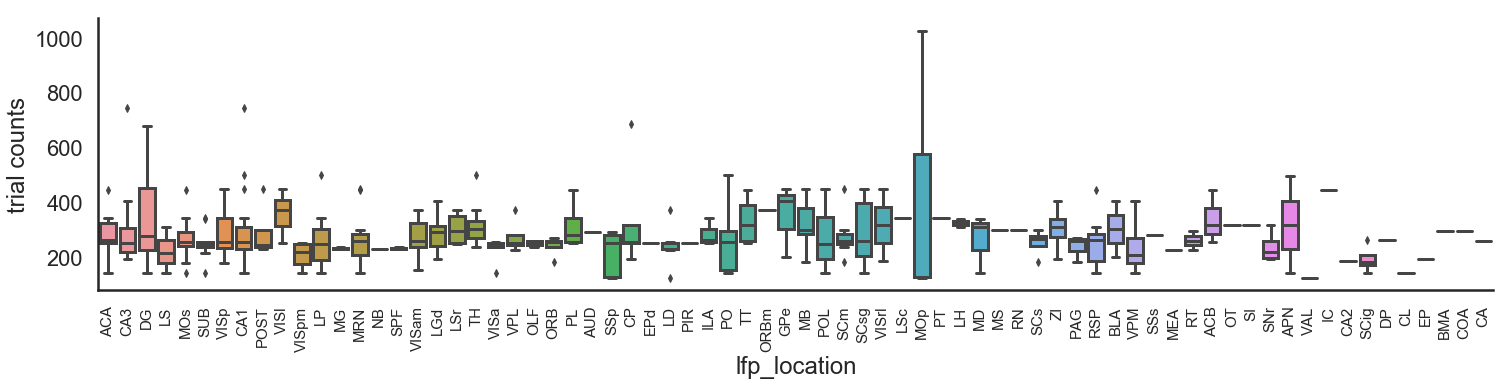

In [165]:
tmpdf = (
    lfp_df
#     .query('neuron_location == "VISa"')
    .set_index(['session', 'mouse_name','trial_num','lfp_num','lfp_location',])
    .groupby(['session', 'mouse_name', 'lfp_location'])[0]
    .count()
    .rename('trial_counts')
    .reset_index()
)

_, ax = plt.subplots(figsize=(25,5))
sns.boxplot(x='lfp_location', y='trial_counts', data=tmpdf,)
sns.despine()
ax.set_ylabel('trial counts')
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90, fontsize=15);
print(f'Number of LFP areas: {len(ax.get_xticklabels())}')

,lfp_location,time_bin,potention
0,VISam,0,-0.600274
1,VISl,0,-2.210345
2,VISp,0,1.059462
3,VISpm,0,-1.419658
4,VISa,0,1.430531


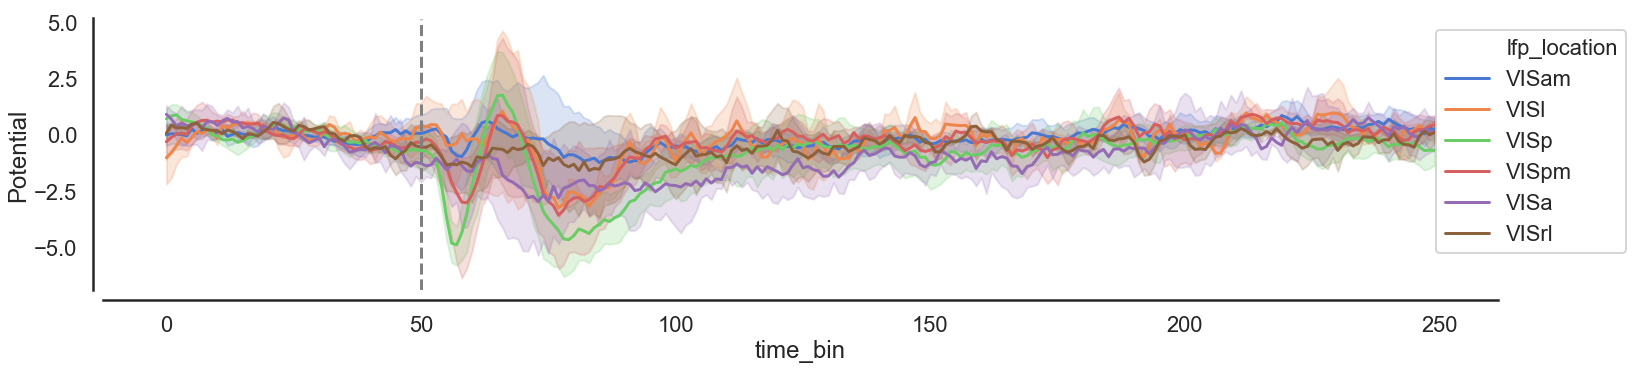

In [214]:
tmpdf = (
    lfp_df
#     .query('neuron_location == "VISa"')
    .set_index(['session', 'mouse_name','trial_num','lfp_num','lfp_location',])
    .groupby(['mouse_name', 'lfp_location'])
    .mean()
#     .rename('trial_counts')
#     .reset_index()
)
tmpdf = pd.melt(
    (tmpdf
     .reset_index()
    .query('lfp_location.str.startswith("VIS")')
    ), 
    id_vars=['lfp_location'], 
    value_vars = [col for col in tmpdf.columns if col != 'lfp_location'],
    var_name='time_bin',
    value_name = 'potention'
)
display(tmpdf.head())
_, ax = plt.subplots(figsize=(25,5))
ax = sns.lineplot(x='time_bin', y='potention', hue='lfp_location', data=tmpdf, ax=ax)
sns.despine(offset=10)
ax.axvline(50, ls='--', color='grey')
ax.set_ylabel('Potential')
ax.legend(bbox_to_anchor=[1.1, 1])
# ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90, fontsize=15);
# print(f'Number of LFP areas: {len(ax.get_xticklabels())}')

## Behavioral Data

In [28]:
#data frame for behavioral data for each session mouse and trial
behavior_df = pd.DataFrame()
#loop through all sessions
for session, data in enumerate(alldat):
#     print(session)    
    tmpdf = pd.DataFrame()
    tmpdf['response'] = data['response']
    tmpdf['feedback_type'] = data['feedback_type']
    tmpdf['response_time'] = data['response_time']
    tmpdf['contract_left'] = data['contrast_left']
    tmpdf['contrast_right'] = data['contrast_right']
    tmpdf['go_cue'] = data['gocue']
    tmpdf['trial_num'] = tmpdf.index.values
    tmpdf['session'] = session
    tmpdf['mouse_name'] = data['mouse_name']
    behavior_df = pd.concat([behavior_df, tmpdf], ignore_index=True)

behavior_df.head()

,response,feedback_type,response_time,contract_left,contrast_right,go_cue,trial_num,session,mouse_name
0,1.0,1.0,1.150204,1.0,0.0,1.027216,0,0,Cori
1,-1.0,1.0,1.399503,0.0,0.5,0.874414,1,0,Cori
2,1.0,1.0,0.949291,1.0,0.5,0.825213,2,0,Cori
3,0.0,1.0,2.266802,0.0,0.0,0.761612,3,0,Cori
4,1.0,-1.0,0.816776,0.5,1.0,0.662010,4,0,Cori


In [59]:
behavior_df.set_index(['session', 'mouse_name','trial_num',])

response  feedback_type  response_time  \
session mouse_name trial_num                                           
0       Cori       0               1.0            1.0       1.150204   
                   1              -1.0            1.0       1.399503   
                   2               1.0            1.0       0.949291   
                   3               0.0            1.0       2.266802   
                   4               1.0           -1.0       0.816776   
...                                ...            ...            ...   
38      Theiler    338             0.0           -1.0       2.297503   
                   339            -1.0           -1.0       1.158803   
                   340             0.0           -1.0       2.003709   
                   341             0.0           -1.0       2.076758   
                   342             0.0           -1.0       2.101029   

                              contract_left  contrast_right    go_cue  
session mouse_name trial_num                                           
0       Cori       0                    1.0            0.00  1.027216  
                   1                    0.0            0.50  0.874414  
                   2                    1.0            0.50  0.825213  
                   3                    0.0            0.00  0.761612  
                   4                    0.5            1.00  0.662010  
...                                     ...             ...       ...  
38      Theiler    338                  1.0            0.25  0.794097  
                   339                  1.0            0.25  0.524700  
                   340                  1.0            0.25  0.504257  
                   341                  1.0            0.25  0.574262  
                   342                  1.0            0.25  0.589720  

[10050 rows x 6 columns]

In [60]:
behavior_df.mouse_name.unique() # so cute

array(['Cori', 'Forssmann', 'Hench', 'Lederberg', 'Moniz', 'Muller',
       'Radnitz', 'Richards', 'Tatum', 'Theiler'], dtype=object)

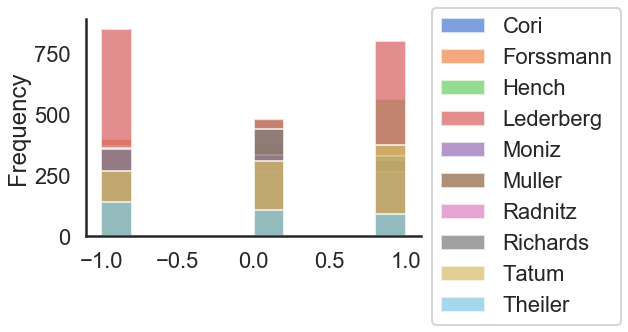

In [114]:
_, ax = plt.subplots()
(
    behavior_df
    .groupby(['mouse_name'])
    .response
    .plot(kind='hist', legend=True, stacked=False, ax=ax, alpha=0.7)
);
ax.legend(bbox_to_anchor=[1., 1.1])
sns.despine()

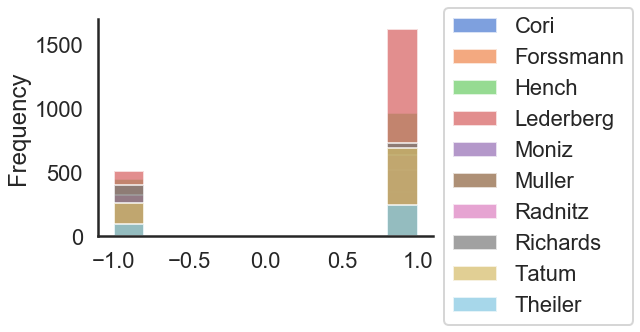

In [117]:
_, ax = plt.subplots()
(
    behavior_df
    .groupby(['mouse_name'])
    .feedback_type
    .plot(kind = 'hist', legend=True, stacked=True, ax=ax, alpha=0.7)
);
ax.legend(bbox_to_anchor=[1., 1.1])
sns.despine()

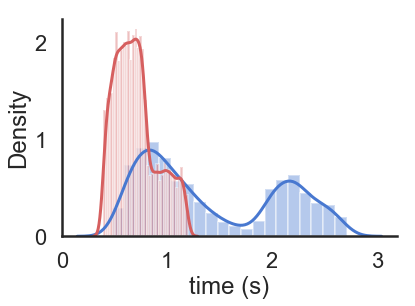

In [215]:
ax = sns.distplot(
    behavior_df
#     .query('contract_left==0 and contrast_right==0.25')
    .response_time,
    color='b'
)
ax = sns.distplot(
    behavior_df
#     .query('contract_left==0 and contrast_right==0.25')
    .go_cue,
    color='r'
)
ax.set_ylabel('Density')
ax.set_xlabel('time (s)')
sns.despine()
#comparison of trialtypes, correct/incorrect, different contrasts 

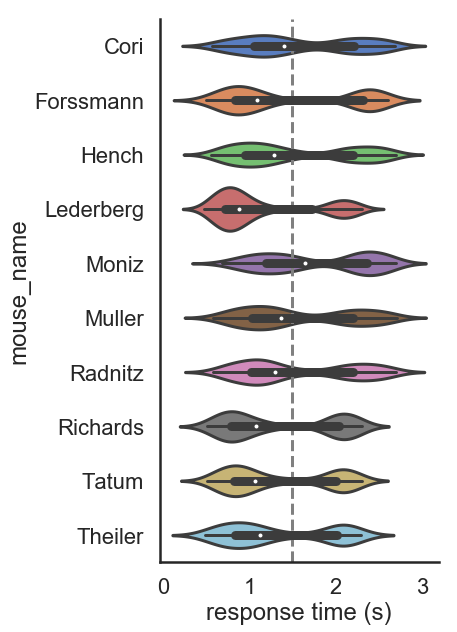

In [186]:
_, ax = plt.subplots(figsize=(5,10))
ax.axvline(1.5, ls='--', color='grey')
ax = sns.violinplot(y='mouse_name', x='response_time', data=behavior_df,)
sns.despine()
ax.set_xlabel('response time (s)');
# ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=0);
## remove trials with response time over 1.5s??

In [224]:
display(behavior_df.query('response_time <= 1.5').groupby('session').trial_num.count())
display(behavior_df.query('response_time > 1.5').trial_num.count())

session
0     116
1     129
2     128
3     120
4     142
5     195
6     182
7     136
8     223
9     260
10    211
11    261
12    237
13    195
14    284
15    195
16    172
17    231
18     97
19    114
20     55
21    293
22     71
23     82
24    171
25    112
26    146
27     64
28     57
29     63
30    158
31    170
32    125
33    143
34    210
35    145
36    109
37    115
38    212
Name: trial_num, dtype: int64

3921